## Introduction

The goal of this notebook is to **compare different methods for option portfolio reduction**.  

In practice, large option portfolios can contain **thousands of positions**, making them difficult to manage and hedge efficiently.  
Portfolio reduction techniques aim to **approximate the original portfolio** with a smaller set of representative positions while **preserving key risk characteristics**.

In this notebook, we explore and compare several approaches to portfolio reduction, **evaluating their effectiveness in terms of P&L spread** across given scenarios.  
The objective is to **identify methods that provide a good trade-off** between **dimensionality reduction** and **fidelity to the original portfolio’s risk profile**.


## Import librairies

In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import itertools as it
import matplotlib.pyplot as plt
from sklearn import linear_model
from python_module.pricing_model import SABRModel

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.2f}'.format

## Custom function

In [2]:
def miqp_l1_cardinality(
    X: pd.DataFrame,
    y: pd.Series,
    C1: float,
    C2: float,
    M: float | None = None,
    solver: str | None = None,
    verbose: bool = False,
):
    """
    Solve:
        minimize   ||X beta - y||_2^2
        s.t.       sum_j |beta_j| <= C1
                   #{j: beta_j != 0} <= C2

    using a Mixed-Integer Quadratic Program (MIQP) in CVXPY.

    Parameters
    ----------
    X : pd.DataFrame
        Shape (n, p). Rows = samples, columns = features.
        Must be convertible to numeric (float).
    y : pd.Series
        Length n. Index should align with X.index (order is matched by X.index).
        Must be convertible to numeric (float).
    C1 : float
        Upper bound on L1 norm of beta: sum |beta_j| <= C1.
    C2 : float
        Upper bound on number of selected features (cardinality).
    M : float or None, optional
        Big-M constant for linking binary z and beta.
        If None, it is estimated from a least squares fit.
    solver : str or None, optional
        Name of CVXPY solver, e.g. "GUROBI", "CPLEX", "MOSEK", "ECOS_BB".
    verbose : bool, optional
        If True, prints solver output.

    Returns
    -------
    beta_hat : pd.Series
        Estimated coefficients, indexed by X.columns.
    z_hat : pd.Series
        Binary feature selection indicators (0/1), indexed by X.columns.
    problem : cp.Problem
        The underlying CVXPY problem.
    """

    # --- Align y to X's index ---
    y = y.loc[X.index]

    # --- Force numeric types and give useful errors if conversion fails ---
    try:
        X_val = X.to_numpy(dtype=float)
    except Exception as e:
        # Find problematic columns
        non_numeric_cols = [
            col for col in X.columns
            if not pd.api.types.is_numeric_dtype(X[col])
        ]
        raise TypeError(
            "X contains non-numeric columns or values that "
            "cannot be converted to float.\n"
            f"Problematic columns (first guess): {non_numeric_cols}\n"
            f"Original error: {e}"
        )

    try:
        y_val = y.to_numpy(dtype=float)
    except Exception as e:
        raise TypeError(
            "y contains values that cannot be converted to float.\n"
            f"Original error: {e}"
        )

    n, p = X_val.shape
    C2_int = int(np.floor(C2))

    # --- Big-M estimation (if not provided) ---
    if M is None:
        try:
            beta_ls, *_ = np.linalg.lstsq(X_val, y_val, rcond=None)
            max_abs_beta = np.max(np.abs(beta_ls)) if beta_ls.size > 0 else 1.0
            if max_abs_beta <= 0:
                max_abs_beta = 1.0
            M = 10.0 * max_abs_beta  # some margin
        except np.linalg.LinAlgError:
            M = 1e3  # fallback

    if M <= 0:
        M = 1e3

    # --- Decision variables ---
    beta = cp.Variable(p)
    t = cp.Variable(p)
    z = cp.Variable(p, boolean=True)

    # --- Objective ---
    residual = X_val @ beta - y_val
    objective = cp.Minimize(cp.sum_squares(residual))

    # --- Constraints ---
    constraints = []

    # L1 norm: |beta_j| <= t_j, t_j >= 0, sum t_j <= C1
    constraints += [t >= beta]
    constraints += [t >= -beta]
    constraints += [t >= 0]
    constraints += [cp.sum(t) <= C1]

    # Big-M linking beta and t with z
    constraints += [beta <= M * z]
    constraints += [beta >= -M * z]
    constraints += [t <= M * z]

    # Cardinality constraint
    constraints += [cp.sum(z) <= C2_int]

    # Build problem
    problem = cp.Problem(objective, constraints)

    # --- Choose solver if not provided ---
    if solver is None:
        preferred_solvers = [
            cp.GUROBI,
            cp.CPLEX,
            cp.MOSEK,
            getattr(cp, "XPRESS", None),
            getattr(cp, "SCIP", None),
            cp.ECOS_BB,
        ]
        installed = set(cp.installed_solvers())
        solver = None
        for s in preferred_solvers:
            if s is not None and s in installed:
                solver = s
                break
        if solver is None:
            raise RuntimeError(
                "No suitable mixed-integer solver found. "
                "Install one of: GUROBI, CPLEX, MOSEK, SCIP, XPRESS, or ECOS_BB."
            )

    # --- Solve ---
    problem.solve(solver=solver, verbose=verbose)

    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError(f"Optimization did not succeed. Status: {problem.status}")

    beta_hat = pd.Series(np.array(beta.value).ravel(), index=X.columns)
    z_hat = pd.Series(np.array(z.value).ravel(), index=X.columns)

    # Make z strictly binary (0/1) for convenience
    z_hat = (z_hat > 0.5).astype(int)

    return beta_hat, z_hat, problem


In [3]:
def miqp_l1_cardinality_v2(
    X: pd.DataFrame,
    y: pd.Series,
    C1: float,
    C2: float,
    M: float | None = None,
    solver: str | None = None,
    verbose: bool = False,
    target_risk=None,
    risk_grid=None,
):
    """
    Solve:
        minimize   ||X beta - y||_2^2
        s.t.       sum_j |beta_j| <= C1
                   #{j: beta_j != 0} <= C2
                   (optional) risk_grid^T beta = target_risk

    using a Mixed-Integer Quadratic Program (MIQP) in CVXPY.

    Parameters
    ----------
    X : pd.DataFrame
        Shape (n, p). Rows = samples, columns = features (decision variables).
    y : pd.Series
        Length n. Index should align with X.index.
    C1 : float
        Upper bound on L1 norm of beta: sum |beta_j| <= C1.
    C2 : float
        Upper bound on number of selected features (cardinality).
    M : float or None, optional
        Big-M constant for linking binary z and beta.
    solver : str or None, optional
        Name of CVXPY solver, e.g. "GUROBI", "CPLEX", "MOSEK", "ECOS_BB".
    verbose : bool, optional
        If True, prints solver output.
    target_risk : array-like or pd.Series or None, optional
        Vector of target risk exposures (e.g. [vega, vanna, volga, theta]).
        If provided, must have length equal to the number of risk factors
        (columns of risk_grid).
    risk_grid : pd.DataFrame or array-like or None, optional
        Matrix of risk exposures of each decision variable (column of X)
        to each risk factor.
        Expected shape: (p, k) where p = X.shape[1] and k = number of risk factors.
        If a DataFrame, its index must match X.columns (same order).

    Returns
    -------
    beta_hat : pd.Series
        Estimated coefficients, indexed by X.columns.
    z_hat : pd.Series
        Binary feature selection indicators (0/1), indexed by X.columns.
    problem : cp.Problem
        The underlying CVXPY problem.
    """

    # --- Align y to X's index ---
    y = y.loc[X.index]

    # --- Force numeric types and give useful errors if conversion fails ---
    try:
        X_val = X.to_numpy(dtype=float)
    except Exception as e:
        non_numeric_cols = [
            col for col in X.columns
            if not pd.api.types.is_numeric_dtype(X[col])
        ]
        raise TypeError(
            "X contains non-numeric columns or values that "
            "cannot be converted to float.\n"
            f"Problematic columns (first guess): {non_numeric_cols}\n"
            f"Original error: {e}"
        )

    try:
        y_val = y.to_numpy(dtype=float)
    except Exception as e:
        raise TypeError(
            "y contains values that cannot be converted to float.\n"
            f"Original error: {e}"
        )

    n, p = X_val.shape
    C2_int = int(np.floor(C2))

    # --- Big-M estimation (if not provided) ---
    if M is None:
        try:
            beta_ls, *_ = np.linalg.lstsq(X_val, y_val, rcond=None)
            max_abs_beta = np.max(np.abs(beta_ls)) if beta_ls.size > 0 else 1.0
            if max_abs_beta <= 0:
                max_abs_beta = 1.0
            M = 10.0 * max_abs_beta  # some margin
        except np.linalg.LinAlgError:
            M = 1e3  # fallback

    if M <= 0:
        M = 1e3

    # --- Decision variables ---
    beta = cp.Variable(p)
    t = cp.Variable(p)
    z = cp.Variable(p, boolean=True)

    # --- Objective ---
    residual = X_val @ beta - y_val
    objective = cp.Minimize(cp.sum_squares(residual))

    # --- Constraints ---
    constraints = []

    # L1 norm: |beta_j| <= t_j, t_j >= 0, sum t_j <= C1
    constraints += [t >= beta]
    constraints += [t >= -beta]
    constraints += [t >= 0]
    constraints += [cp.sum(t) <= C1]

    # Big-M linking beta and t with z
    constraints += [beta <= M * z]
    constraints += [beta >= -M * z]
    constraints += [t <= M * z]

    # Cardinality constraint
    constraints += [cp.sum(z) <= C2_int]

    # --- Optional risk constraints (hard) ---
    if (target_risk is not None) ^ (risk_grid is not None):
        raise ValueError(
            "Both `target_risk` and `risk_grid` must be provided together, or both None."
        )

    if target_risk is not None and risk_grid is not None:
        # risk_grid: shape (p, k), one row per decision variable (column of X)
        if isinstance(risk_grid, pd.DataFrame):
            try:
                # ensure rows are in the same order as X.columns
                risk_grid_val = risk_grid.loc[X.columns].to_numpy(dtype=float)
            except KeyError:
                raise KeyError(
                    "When `risk_grid` is a DataFrame, its index must match X.columns."
                )
        else:
            risk_grid_val = np.asarray(risk_grid, dtype=float)

        # Accept 1D or 2D
        if risk_grid_val.ndim == 1:
            if risk_grid_val.shape[0] != p:
                raise ValueError(
                    "1D `risk_grid` length must equal the number of columns of X."
                )
            risk_grid_val = risk_grid_val[:, None]  # (p,) -> (p, 1)
        elif risk_grid_val.ndim == 2:
            if risk_grid_val.shape[0] != p:
                raise ValueError(
                    "`risk_grid` must have shape (p, k) with p = X.shape[1]."
                )
        else:
            raise ValueError("`risk_grid` must be 1D or 2D array-like.")

        # target_risk: shape (k,)
        if isinstance(target_risk, pd.Series) or isinstance(target_risk, pd.DataFrame):
            target_risk_val = np.asarray(target_risk, dtype=float).ravel()
        else:
            target_risk_val = np.asarray(target_risk, dtype=float).ravel()

        k = risk_grid_val.shape[1]
        if target_risk_val.shape[0] != k:
            raise ValueError(
                "Length of `target_risk` must equal the number of risk factors "
                f"(risk_grid has {k} columns, target_risk has {target_risk_val.shape[0]})."
            )

        # risk_grid^T * beta = target_risk  (vector equality)
        risk_expr = risk_grid_val.T @ beta  # shape (k,)
        constraints += [risk_expr == target_risk_val]

    # Build problem
    problem = cp.Problem(objective, constraints)

    # --- Choose solver if not provided ---
    if solver is None:
        preferred_solvers = [
            cp.GUROBI,
            cp.CPLEX,
            cp.MOSEK,
            getattr(cp, "XPRESS", None),
            getattr(cp, "SCIP", None),
            cp.ECOS_BB,
        ]
        installed = set(cp.installed_solvers())
        solver = None
        for s in preferred_solvers:
            if s is not None and s in installed:
                solver = s
                break
        if solver is None:
            raise RuntimeError(
                "No suitable mixed-integer solver found. "
                "Install one of: GUROBI, CPLEX, MOSEK, SCIP, XPRESS, or ECOS_BB."
            )

    # --- Solve ---
    problem.solve(solver=solver, verbose=verbose)

    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError(f"Optimization did not succeed. Status: {problem.status}")

    beta_hat = pd.Series(np.array(beta.value).ravel(), index=X.columns)
    z_hat = pd.Series(np.array(z.value).ravel(), index=X.columns)

    # Make z strictly binary (0/1) for convenience
    z_hat = (z_hat > 0.5).astype(int)

    return beta_hat, z_hat, problem

In [4]:
def tune_lasso_alpha(X, y, desired_nonzero, alpha_start=1e-4, alpha_end=1e5, 
                     max_iter=100, tol=1e-3, fit_intercept=False, verbose=False):
    """
    Automatically adjusts alpha for a Lasso model to reach a desired number of non-zero coefficients.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Input data (gamma_grid in your case).
    y : array-like, shape (n_samples,)
        Target values (gamma_at_spot in your case).
    desired_nonzero : int
        Desired number of non-zero coefficients.
    alpha_start, alpha_end : float
        Range of alpha values to explore.
    max_iter : int
        Maximum number of binary search iterations.
    tol : float
        Allowed difference between achieved and desired non-zero count.
    fit_intercept : bool
        Whether to include an intercept in the model.
    verbose : bool
        If True, prints progress information.

    Returns
    -------
    model : fitted sklearn.linear_model.Lasso object
    alpha : float
        The alpha value found that gives approximately the desired number of non-zero coefficients.
    """

    # Binary search setup
    low, high = alpha_start, alpha_end
    best_model, best_alpha = None, None

    for i in range(max_iter):
        alpha = (low + high) / 2
        model = linear_model.Lasso(alpha=alpha, fit_intercept=fit_intercept, max_iter=10000)
        model.fit(X, y)
        nonzero = np.sum(model.coef_ != 0)

        if verbose:
            print(f"Iter {i:2d}: alpha={alpha:.5f}, nonzero={nonzero}")

        # Check if we’re close enough
        if abs(nonzero - desired_nonzero) <= tol:
            best_model, best_alpha = model, alpha
            break

        # Adjust search bounds
        if nonzero > desired_nonzero:
            # Too many features active → increase alpha
            low = alpha
        else:
            # Too few features active → decrease alpha
            high = alpha

        best_model, best_alpha = model, alpha

    return best_model, best_alpha


In [5]:
def best_subset_weights(X, y, k, max_sum_abs_weight=np.inf):
    """
    Brute-force search for the best subset of k features (columns) in X.

    For each subset of size k:
      1. Fit least squares regression y ~ X[:, subset]
      2. Discard solutions where sum(abs(weights)) > max_sum_abs_weight
      3. Compute MSE on the training data
    Returns the weight vector (as a pandas Series) for the best valid subset,
    with zeros for features not selected.
    """
    Xv = X.values
    yv = y.values
    n_features = Xv.shape[1]

    best_mse = np.inf
    best_subset = None
    best_weights = None

    # Loop over all subsets of size k
    for subset in it.combinations(range(n_features), k):
        subset = list(subset)
        X_sub = Xv[:, subset]

        # Least squares solution on the subset
        weights, *_ = np.linalg.lstsq(X_sub, yv, rcond=None)

        # Enforce L1-type constraint on weights
        if np.sum(np.abs(weights)) > max_sum_abs_weight:
            continue  # invalid solution, skip

        # Compute mean squared error
        residuals = yv - X_sub @ weights
        mse = np.mean(residuals ** 2)

        # Keep track of best (lowest-MSE) valid solution
        if mse < best_mse:
            best_mse = mse
            best_subset = subset
            best_weights = weights

    if best_subset is None:
        raise ValueError(
            "No valid solution found: all subsets violate max_sum_abs_weight."
        )

    # Build full weight vector with zeros for non-selected features
    full_weights = np.zeros(n_features)
    full_weights[best_subset] = best_weights

    return pd.Series(full_weights, index=X.columns)

## Generate Market data

In [6]:
# -------
# INPUTS
# -------

params = {
    
    'Start': {
        "F": 1000,
        "T": 5/250,
        "alpha": 0.1,
        "rho": -0.5,
        "nu": 0.5},
    
    "End": {
        "F": 980,
        "T": 4/250,
        "alpha": 0.1,
        "rho": -0.9,
        "nu": 1.0}
}

beta = 1
r = 0

# Generate options
results = dict()

for key in params.keys():
    globals().update(params[key])
    for K in range(940, 1060, 5):
        out = dict()
        option_type = 'call' if K > F else 'put'
        out = SABRModel.compute_option(F, K, T, alpha, beta, rho, nu, r, option_type=option_type, compute_bs_greeks=False, compute_model_greek=True)
        results[(key, K)] = out
        
results = pd.DataFrame(results).unstack().unstack()
results = results.reset_index(names=['index', 'strike'])
start_df = results[results['index']=='Start'].reset_index(drop=True)
end_df = results[results['index']=='End'].reset_index(drop=True)

## Generate weights and plot gamma cash profile 

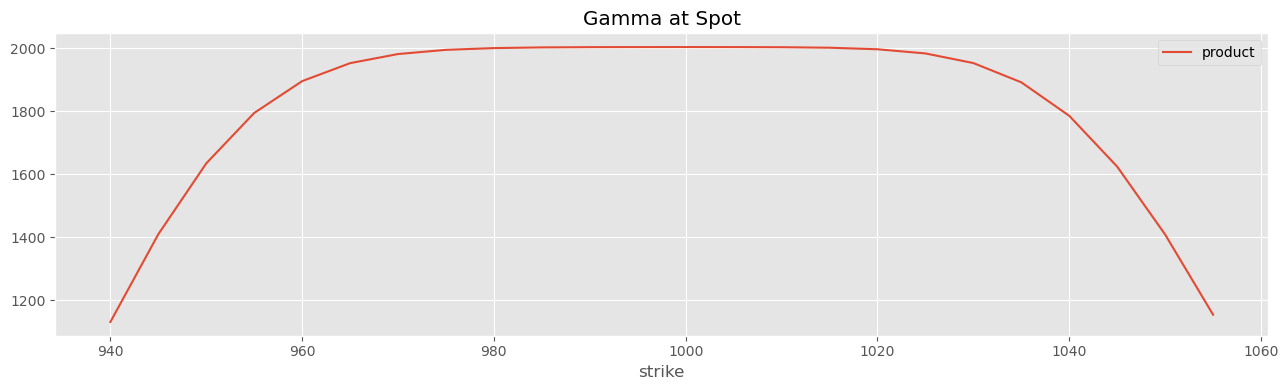

In [7]:
start_df['weight'] = (1 / np.power(start_df['strike'], 2)) * 1_000_000
gamma_grid = pd.DataFrame(index=start_df['strike'], columns=start_df['strike'])

globals().update(params['Start'])
for F in gamma_grid.index:
    for K in gamma_grid.columns:
        cash_coeff = (F**2) / 100 
        gamma = SABRModel.compute_option(F, K, T, alpha, beta, rho, nu, r, option_type=option_type, compute_bs_greeks=True, compute_model_greek=False)['gamma']
        gamma_grid.loc[F, K] = gamma * cash_coeff
gamma_at_spot = gamma_grid.multiply(start_df.set_index('strike')['weight']).sum(axis=1)
gamma_at_spot_df = pd.DataFrame()
gamma_at_spot_df['product'] = gamma_at_spot
plt.style.use("ggplot") 
plt.figure(figsize=(13, 4))
sns.lineplot(data=gamma_at_spot_df[['product']])   # uses the index as x and each column as a separate line
plt.title("Gamma at Spot")
plt.tight_layout()
plt.show()

## 0. Delta bucket gamma flat

Compute total gamma / theta for each "delta call bucket"

Select the option with the least quantity to trade.

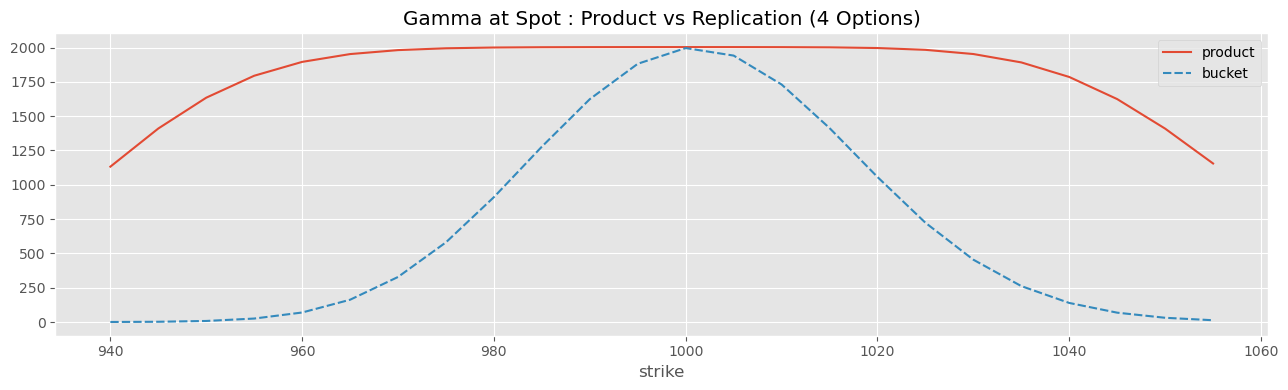

In [9]:
# Delta Bucketing
df = start_df.copy()
df['delta_call'] = (1+df['sabr_delta']) * (df['sabr_delta'] < 0).astype(int) + (df['sabr_delta']) * (df['sabr_delta'] > 0).astype(int)
df['str_delta_call'] = df['delta_call'].apply(lambda x: f"{x:.2f}")
df['max_gamma_small_bucket'] = df['str_delta_call'].map(df.groupby('str_delta_call')['sabr_gamma'].max())
bins = [0, 0.25, 0.5, 0.75, 1]
labels = ['0-0.25', '0.25-0.5', '0.5-0.75', '0.75-1']
df['delta_bucket'] = pd.cut(df['delta_call'], bins=bins, labels=labels)

# Compute adjusted ref risk for portfolio reduction
risk_ref = 'sabr_gamma'
df[f'pos_{risk_ref}'] = df[risk_ref] * df['weight']

# Compute weight_reduction with discrete approach
df['risk_bucket'] = list(df['delta_bucket'].map(df.groupby('delta_bucket', observed=True)[f'pos_{risk_ref}'].sum().to_dict()))
df['qty_to_trade'] = df['risk_bucket'] / df[risk_ref]
df['min_qty_to_trade'] = list(df['delta_bucket'].map(df.groupby('delta_bucket', observed=True)['qty_to_trade'].min().to_dict())) 
df['weight_reduction'] = (df['qty_to_trade']==df['min_qty_to_trade']) * df['min_qty_to_trade']
df['weight_reduction'] = df['weight_reduction'].replace(0, np.nan)
df['gamma_cash']  = (df['sabr_gamma']*F**2)
start_df.loc[:, 'bucket'] = 0.0
start_df.loc[:, 'bucket'] = df['weight_reduction'].values
gamma_at_spot_df['bucket'] = gamma_grid.multiply(start_df.set_index('strike')['bucket']).sum(axis=1)
plt.style.use("ggplot") 
plt.figure(figsize=(13, 4))
sns.lineplot(data=gamma_at_spot_df[['product', 'bucket']])   # uses the index as x and each column as a separate line
plt.title("Gamma at Spot : Product vs Replication (4 Options)")
plt.tight_layout()
plt.show()

## 1. Descrete Strike - Matrix Inversion

Select a set of discrete strikes and extracts the corresponding submatrix A from gamma_grid and the vector b from gamma_at_spot_df. 

It then solves the linear system A x = b to compute the local-replication weights for those strikes.

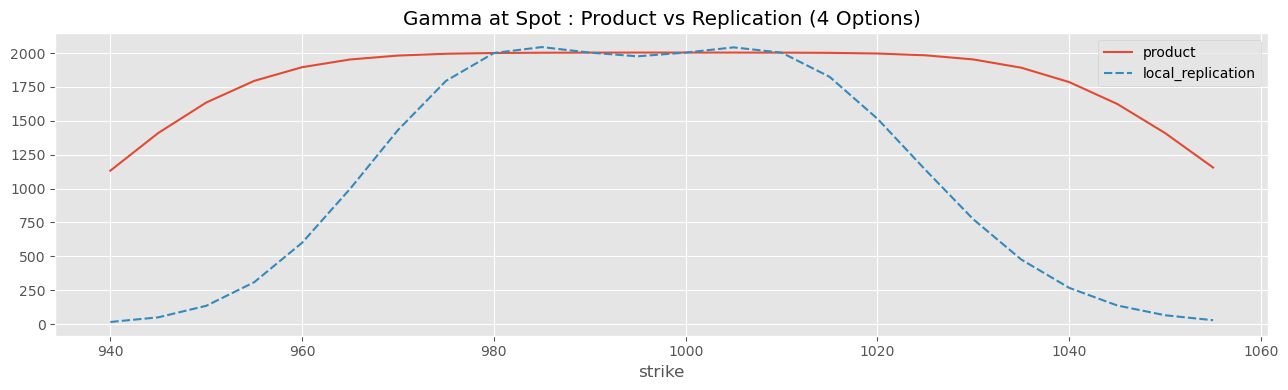

In [10]:
descrete_strikes = [980, 990, 1000, 1010]
A = np.asarray(gamma_grid.loc[descrete_strikes, descrete_strikes], dtype=float)
b = np.asarray(gamma_at_spot_df.loc[descrete_strikes, 'product'], dtype=float).reshape(-1)
start_df.loc[start_df['strike'].isin(descrete_strikes), 'local_replication'] = np.linalg.solve(A, b)
gamma_at_spot_df['local_replication'] = gamma_grid.multiply(start_df.set_index('strike')['local_replication']).sum(axis=1)

plt.style.use("ggplot") 
plt.figure(figsize=(13, 4))
sns.lineplot(data=gamma_at_spot_df[['product', 'local_replication']])   # uses the index as x and each column as a separate line
plt.title("Gamma at Spot : Product vs Replication (4 Options)")
plt.tight_layout()
plt.show()

## 2. Descrete Delta - Brute Force Matrix Inversion

Compute "delta call bucket" then find, for each "delta call bucket", the option with maximum gamma. 

The rows corresponding to these maximum-gamma strikes are extracted to build a reduced gamma matrix.

Perform an exhaustive (brute-force) search over all subsets of 4 strikes. 

For each subset, the function solves a least-squares regression and filters out solutions based on below constraints.

\begin{aligned}
\text{s.t.} \quad 
&\sum_{j} |\beta_j| \le C_1, \\
&\#\{ j : \beta_j \neq 0 \} \le C_2.
\end{aligned}

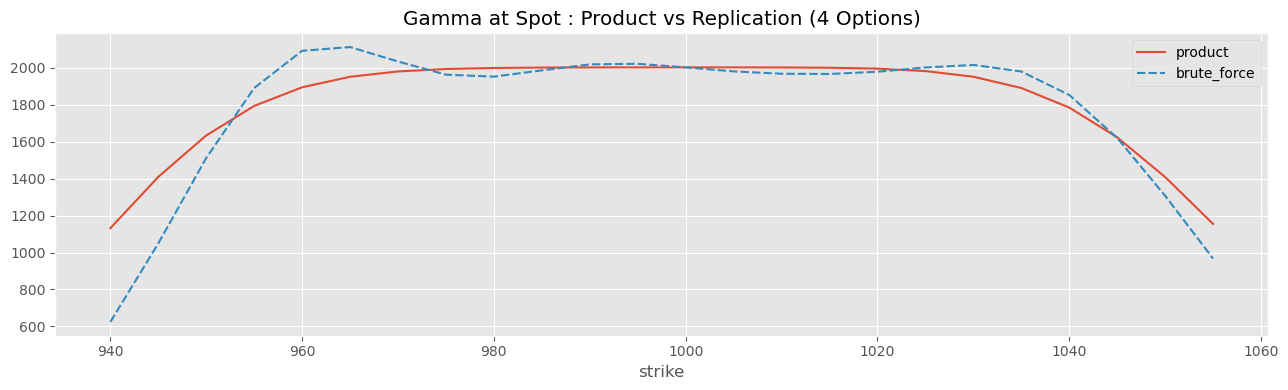

In [11]:
df = start_df.copy()
df['delta_call'] = (1+df['sabr_delta']) * (df['sabr_delta'] < 0).astype(int) + (df['sabr_delta']) * (df['sabr_delta'] > 0).astype(int)
df['str_delta_call'] = df['delta_call'].apply(lambda x: f"{x:.2f}")
df['max_gamma_small_bucket'] = df['str_delta_call'].map(df.groupby('str_delta_call')['sabr_gamma'].max())
df_sub = df.loc[df['sabr_gamma']==df['max_gamma_small_bucket']].copy()
sub_gamma_grid = gamma_grid.loc[:, df_sub['strike']]
res = best_subset_weights(sub_gamma_grid.astype(float), gamma_at_spot_df['product'].astype(float), 4, max_sum_abs_weight=start_df['weight'].abs().sum() * 100)
start_df.loc[:, 'brute_force'] = 0.0
start_df.loc[:, 'brute_force'] = start_df['strike'].map(res).astype(float).fillna(0)
gamma_at_spot_df['brute_force'] = gamma_grid.multiply(start_df.set_index('strike')['brute_force']).sum(axis=1)
plt.style.use("ggplot") 
plt.figure(figsize=(13, 4))
sns.lineplot(data=gamma_at_spot_df[['product', 'brute_force']])   # uses the index as x and each column as a separate line
plt.title("Gamma at Spot : Product vs Replication (4 Options)")
plt.tight_layout()
plt.show()

## 3. Mixed-Integer Quadratic Program

\begin{aligned}
\text{Solve:} \quad 
&\min_{\beta} \ \|X\beta - y\|_2^2 \\
\text{s.t.} \quad 
&\sum_{j} |\beta_j| \le C_1, \\
&\#\{ j : \beta_j \neq 0 \} \le C_2.
\end{aligned}

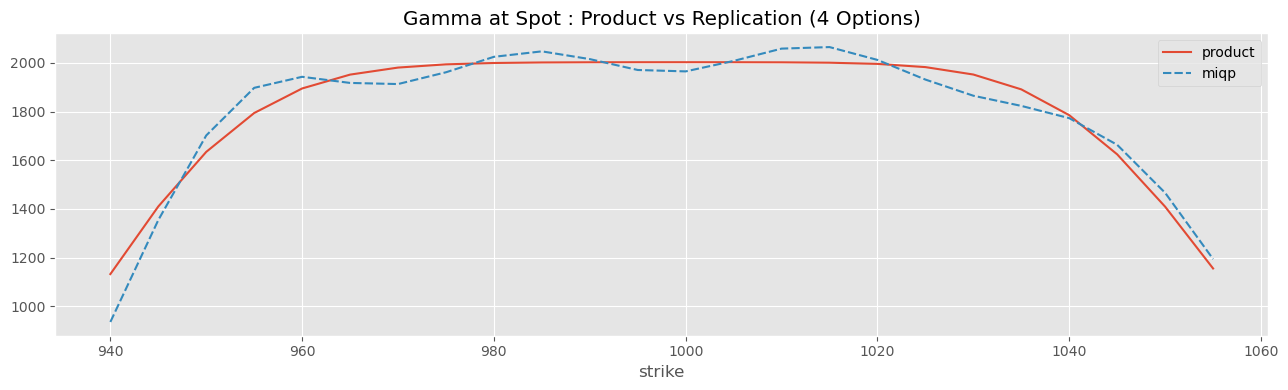

In [12]:
res = miqp_l1_cardinality(
    X=gamma_grid,
    y=gamma_at_spot_df['product'],
    C1=start_df['weight'].abs().sum() * 100,
    C2=4,
    M=None,
    solver=None,
    verbose=False)
res = res[0]
start_df.loc[:, 'miqp'] = 0.0
start_df.loc[:, 'miqp'] = start_df['strike'].map(res).astype(float).fillna(0)
gamma_at_spot_df['miqp'] = gamma_grid.multiply(start_df.set_index('strike')['miqp']).sum(axis=1)
plt.style.use("ggplot") 
plt.figure(figsize=(13, 4))
sns.lineplot(data=gamma_at_spot_df[['product', 'miqp']])   # uses the index as x and each column as a separate line
plt.title("Gamma at Spot : Product vs Replication (4 Options)")
plt.tight_layout()
plt.show()

## 4. Mixed-Integer Quadratic Program with headline risk constraint

\begin{aligned}
\textbf{Solve:} \qquad 
&\min_{\beta} \ \|X\beta - y\|_2^2 \\[6pt]
\textbf{s.t.} \qquad
&\sum_{j} |\beta_j| \le C_1, \\[4pt]
&\#\{ j : \beta_j \neq 0 \} \le C_2, \\[4pt]
& R^\top \beta = r.
\end{aligned}


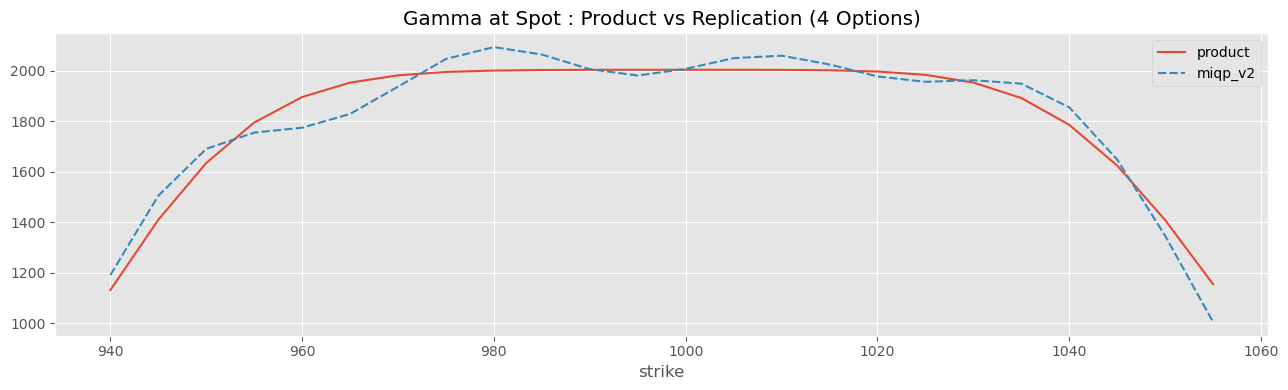

In [17]:
risk_cols = ['sabr_vega', 'sabr_vanna', 'sabr_volga', 'sabr_theta']
risk_cols = ['sabr_theta']
target_risk = start_df[risk_cols].multiply(start_df['weight'], 0).sum()
risk_grid = start_df.set_index('strike').loc[gamma_grid.index, risk_cols]
res = miqp_l1_cardinality_v2(
    X=gamma_grid,
    y=gamma_at_spot_df['product'],
    C1=start_df['weight'].abs().sum() * 100,
    C2=4,
    M=None,
    solver=None,
    verbose=False,
    target_risk=target_risk,
    risk_grid=risk_grid
)
res = res[0]
start_df.loc[:, 'miqp_v2'] = 0.0
start_df.loc[:, 'miqp_v2'] = start_df['strike'].map(res).astype(float).fillna(0)
gamma_at_spot_df['miqp_v2'] = gamma_grid.multiply(start_df.set_index('strike')['miqp_v2']).sum(axis=1)
plt.style.use("ggplot") 
plt.figure(figsize=(13, 4))
sns.lineplot(data=gamma_at_spot_df[['product', 'miqp_v2']])   # uses the index as x and each column as a separate line
plt.title("Gamma at Spot : Product vs Replication (4 Options)")
plt.tight_layout()
plt.show()

## 5. Plot

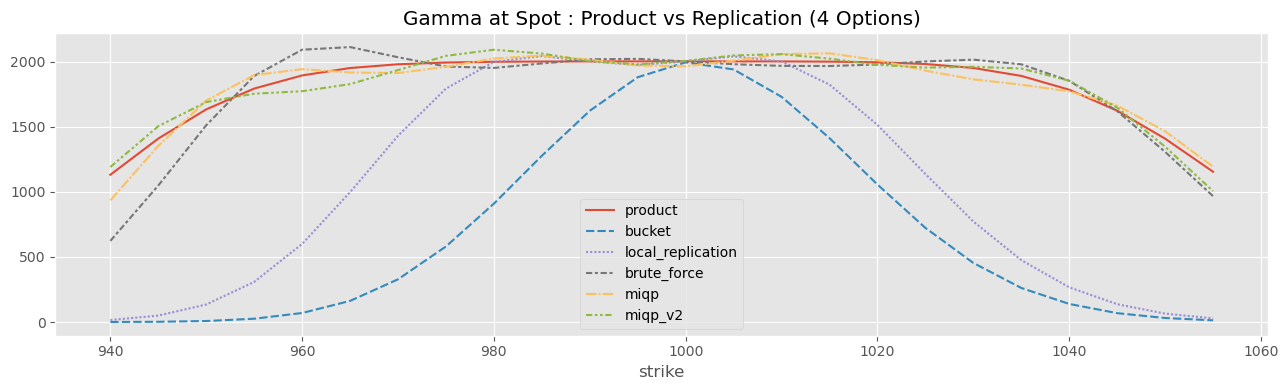

In [18]:
plt.style.use("ggplot") 
plt.figure(figsize=(13, 4))
sns.lineplot(data=gamma_at_spot_df)   # uses the index as x and each column as a separate line
plt.title("Gamma at Spot : Product vs Replication (4 Options)")
plt.tight_layout()
plt.show()